## NDAC Demo
this demo shows the use of our python package, NDAC. Here, all module functionalities emphasizes the simplicity of our workflow and how easy it is for the user to predict protein expression from his/her dataset, from pre-processing to model training with our modified CNN-LSTM architecture. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#the following 2 lines are required if ndac is not installed
import sys
sys.path.append("..") 
import ndac

from ndac.data_processing import quantile_classify, encode_sequence, value_classify
from ndac.predict import train_model

/Users/joshsmith/Git/NovoNordisk_Capstone/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Raw data import
The basic raw data should be a colum of a measured experimental values to be used as a metric for classifciation (eg. expression or solubility) and a sequence (eg. amino acid or nucleotide).  The data will be imported as a pandas dataframe so more than the minimum 2 colums is acceptable.

In the example below, there are 6 columns.  The 'conc_cf' (protein experssion level) will be used as the metric and 'nt_seq' will serve as the sequence. 

In [2]:
# read in sequence/property data
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)
data.head()

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124


## Data processing
Data that are labeled with an emperimental value as a metric are classified.  There are two functions available for classicication. `quntile_classify` calssifies based on the first and forth quantiles or user defined quntiles and `value_classify` classifies based on user input values for high and low values.

### `quantile_classify`
Classify low values as 0, remove middle values, and classify high values as 1.  The default is to calssify the lowest 25% of values as 0, remove the middle 50% and label the to 25% as 1.

45206 samples input.
11302 samples in class 0
11301 samples in class 1
22603 samples removed.


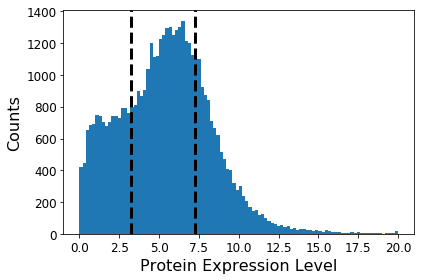

In [3]:
# split quantiles and encode with nucleotide sequence
df, hist = quantile_classify(data['conc_cf'], data['nt_seq'],
                             [0.25, 0.75], drop_class=[1])

## `value_classify`

Classify values below low_value as 0, classify values above high_value as 1 and remove values in between.


45206 samples input.
10289 samples in class 0
32530 samples in class 1
2387 samples in class 2
0 samples removed.


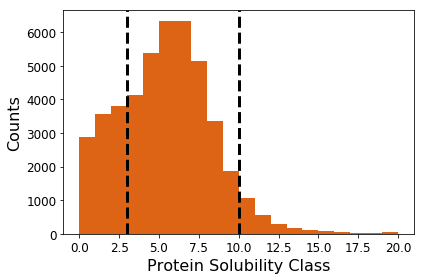

In [4]:
# We can do the same with amino acid sequences
val_df, val_hist = ndac.value_classify(data['conc_cf'], 
                                       data['aa_seq'], 
                                       split_values = [3.0, 10.0])

## `encode_sequence`

This function converts raw nucleotide or amino acid sequences into a vectorized representation, where each codon has a value between 0 and 64 and each amino acid residue has some value between 0 and 20 

In [5]:
X, y = encode_sequence(df['nt_seq'], df['class'],
                       max_length=200, tag='GACAAGCTTGCGGCCGCA')
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20, 33,
       44, 11, 46,  6, 50,  1,  2,  2,  4, 29,  4, 20, 49, 59, 11, 43,  5,
        5, 48,  1,  9,  2,  4, 16,  1,  1, 58,  1,  6,  2, 59,  1,  1,  3,
        9, 26,  1,  1,  1,  2,  1, 49, 22, 31,  2, 18,  9, 40, 15, 25, 30,
       16, 36, 55, 16,  3, 52, 11,  6, 43, 33,  2,  1, 50, 49, 21, 22,  2,
       17, 32,  2, 57,  5, 44, 14, 49, 19, 12, 14, 48, 19, 25,  4, 21, 40,
       52, 22, 38, 44, 44, 23, 46, 52, 60,  6, 11, 24, 52, 48, 17,  5, 15,
       19,  6, 59, 31, 27, 11, 24, 29, 26, 26, 35, 38,  5,  3, 58, 31, 29,
       51, 35,  7, 35, 26, 57, 34, 25, 46,  6, 39,  1, 18,  7,  1, 35, 31,
       35, 23, 11, 32, 53,  1, 41,  4, 18,  5,  8, 14, 42], dtype=int32)

## Model training

## `train_model`

This function takes the post-processed data, train the optimized model and outputs a saved model. 

In [6]:
# default embedding layer length of 10
nt_model = train_model(X, y, test_fraction=0.3, epochs=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 10)           740       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          3968      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 96,409
Trainable params: 96,409
Non-trainable params: 0
_________________________________________________________________
None
Train on 15677 samples, validate on 6719 samples
E

In [7]:
# set embedding length falsy to skip embedding in favor of 1 hot
one_hot_clstm = train_model(X, y, test_fraction=0.3, 
                            epochs=1, embedding_length=None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 200, 128)          28544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 120,245
Trainable params: 120,245
Non-trainable params: 0
_________________________________________________________________
None
Train on 15677 samples, validate on 6719 samples
Epoch 1/1
15677/15677 [==============================] - 36s 2ms/step - loss: 0.6838 - acc: 0.5455 - val_loss: 0.6445 - val_acc: 0.6371
Accuracy: 63.71%


In [8]:
# change architecture flag for LSTM or CNN alone
lstm = train_model(X, y, test_fraction=0.3, architecture='lstm', 
                   epochs=1, embedding_length=None)
cnn = train_model(X, y, test_fraction=0.3, architecture='cnn', 
                  epochs=1, embedding_length=None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               70000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 70,101
Trainable params: 70,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 15677 samples, validate on 6719 samples
Epoch 1/1
15677/15677 [==============================] - 39s 3ms/step - loss: 0.6918 - acc: 0.5203 - val_loss: 0.6902 - val_acc: 0.5062
Accuracy: 50.62%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 200, 128)          28544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 128)          0       

# Want to capture our entire worflow??

here ya go:

In [ ]:
data = pd.read_csv('../dataframes/DF_prest.csv', index_col=0)
df, hist = quantile_classify(data['conc_cf'], data['nt_seq'], [0.25, 0.75], drop_class=[1])
X, y = encode_sequence(df['nt_seq'], df['class'], max_length=200)
nt_model = train_clstm(X, y, test_fraction=0.3, epochs=1, save_file='nt_model.h5')

10216 samples input.
2566 samples in class 0
2546 samples in class 1
5104 samples removed.


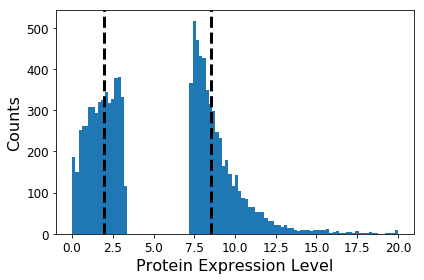

In [3]:
# using Sastry et al. split for retrospective analysis
data = pd.read_csv('DF_train.csv', index_col=0)
df, hist = quantile_classify(data['conc_cf'], data['aa_seq'], [0.25, 0.75], drop_class=[1])
X, y = encode_sequence(data['aa_seq'], data['expressed'], max_length=200)
aa_model = train_clstm(X, y, epochs=35, save_file='aa_model.h5')